# Barshay Second Objective
## A very unsupervised notebook


Most of what I would say here was probably already said in *Barshay Secondary Objective Identification and Description.ipynb* so go check that out if you have not already. Briefly, I will say that my goal here is not to make predictions, I made enough of those in my main objective fitting virtually every scikit-learn machine learning model on the data that I knew about. A lot of this objective was completed in two stages, the first stage where I tried a bunch of various clustering techniques, and the second stage where I learned from some mistakes and was able to make significant improvements.

In [708]:
from bs4 import BeautifulSoup
import json
import pandas as pd
import sklearn
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas.io.json import json_normalize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA
from altair import * 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import matplotlib.pyplot as plt
import re
from sklearn.pipeline import Pipeline
%matplotlib inline

pd.options.display.max_rows = 30

In [709]:
records_train = []
with open("/Users/mdbarshay/Desktop/DATA 301 Project/tensorflow2-question-answering/simplified-nq-train.jsonl") as f:
    v = 0
    for line in f:
        records_train.append(json.loads(line))
        v += 1
        if v > 1000:
            break

I want to now just analyze the question text and do some clustering on it.

In [710]:
training_frame = json_normalize(records_train)

In [711]:
all_questions = training_frame["question_text"]

In [712]:
all_questions

0       which is the most common use of opt-in e-mail ...
1                 how i.met your mother who is the mother
2        what type of fertilisation takes place in humans
3                        who had the most wins in the nfl
4         what happened to the lost settlement of roanoke
                              ...                        
996      the area between the tigris and euphrates rivers
997     the most recent revision of the apa ethics cod...
998                    toby keith - i wanna talk about me
999     where does an apple a day keeps the doctor awa...
1000    what type of oxide are formed when metal combi...
Name: question_text, Length: 1001, dtype: object

I am going to use PCA in order to display this data in two dimensions to see if there are any clear patterns in the data. Since this data is in the form of words (sentences), we cannot simply put it through PCA as words, we need to translate it into something that a machine can understand. For this, I will use a count vectorizer, since I believe common words will be less of a problem in the questions as compared to in the document text since hopefully the questions get to the "meat" of the question more. (in hindsight this might have been a naive assumption).

In [713]:
vec = CountVectorizer() #defining a count vectorizer

In [714]:
vec.fit(all_questions) # fitting it on all the questions

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [715]:
vectorized_words = vec.transform(all_questions) #getting a sparse matrix of words

In [716]:
words_df = pd.DataFrame.sparse.from_spmatrix(vectorized_words) #translating those words to a pandas matrix

In [904]:
words_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I cannot see a single non-zero entry, let me check the value counts on the first observation to make sure that it worked as hoped. Alas, we have some non-zero entrys.

In [718]:
words_df.iloc[0].value_counts()

0    2627
1      11
Name: 0, dtype: int64

In [719]:
len(all_questions.iloc[0].split())

10

For some reason, we seem to get one more non-zero value in each row (observation) of the data frame than we get as the length of our split question. **This is unexpected behaviour that could be caused by whitespace being counted as a word in the vectorizer.**
However, in the long run I do not think that it will affect the results too much.

Now I am fitting PCA (with two components, since two components is pretty much all I can graph sans heat maps) on the sparse data frame to see if I can pick up on any patterns in the various counts of words  from the first 1,000 questions in this data set.

In [720]:
pca = PCA(n_components = 2)

pca.fit(words_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [721]:
pca_data = pca.transform(words_df)

In [722]:
pca_data # This is each questions coordinates where its too coordinates are the first two principal components
# for example: (PC1, PC2).

array([[ 4.87714817e-01, -2.41960313e-01],
       [ 6.24844413e-02,  3.41885842e-01],
       [-5.07501030e-01, -5.10283480e-01],
       ...,
       [-9.19545613e-01, -2.23353898e-01],
       [ 2.10962905e-03, -5.50421888e-04],
       [-5.55585245e-01, -1.09082868e+00]])

In [723]:
new_cols = pd.DataFrame(pca_data,columns=["PC1","PC2"]) # joining the PCA data onto the pandas sparse data frame for
words_df_pca = words_df.join(new_cols) # ease of analysis.

In [905]:
words_df_pca.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2630,2631,2632,2633,2634,2635,2636,2637,PC1,PC2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.487715,-0.241960
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.062484,0.341886
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.507501,-0.510283
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.953555,1.241135
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.365775,-0.751194


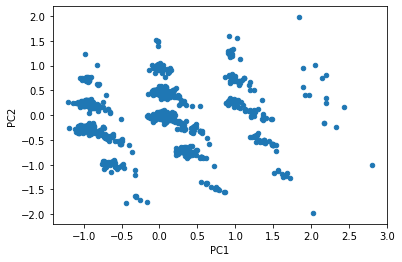

In [725]:
words_df_pca.plot.scatter(x="PC1", y="PC2")

This is a quite an unusual pattern in the data. I wonder what is causing these 4 shapes. It is likely caused by the fact that the length of the word is a discrete variable and so gaps naturally arise. However, there is still a bit left to wonder about the gaps in the y variable although uninterestingly they are probably also caused by length of the word.

I am now going to try to slice this data vertically into the four (vertical) groups that you see on the graph and hopefully I find something interesting and unrelated to just length of the word.

In [726]:
words_df_pca1_sub0 = words_df_pca[words_df_pca["PC1"] < 0] # splitting on every integer on PC1
words_df_pca1_sub1 = words_df_pca[(words_df_pca["PC1"] < 1) & (words_df_pca["PC1"] >= 0)]
words_df_pca1_sub2 = words_df_pca[(words_df_pca["PC1"] < 2) & (words_df_pca["PC1"] >= 1)]
words_df_pca1_sub3 = words_df_pca[(words_df_pca["PC1"] < 3) & (words_df_pca["PC1"] >= 2)]

Above I split the data into four data frames where the first data frame represents the subset of the data that is between -1 and 0 for the first principal component, the second between 0 and 1, the third between 1 and 2, and the fourth between 2 and 3.

Lets have a look at the first data frame that we created.

In [907]:
words_df_pca1_sub0.head() # observations 2, 10, 12, 13 and 14. These do not seem too random,
# but if the questions that were given are in no particular order it we shouldn't be suspicious on these indices

,0,1,2,3,4,5,6,7,8,9,...,2630,2631,2632,2633,2634,2635,2636,2637,PC1,PC2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.507501,-0.510283
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.505286,-0.579496
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.749670,-0.926757
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.966153,0.303921
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.962488,0.310575


Now lets extract the questions using the newly created data frame's indices so that we can index into the original data to see if we can see any patterns.

In [727]:
sub0_questions = all_questions[words_df_pca1_sub0.index]
sub1_questions = all_questions[words_df_pca1_sub1.index]
sub2_questions = all_questions[words_df_pca1_sub2.index]
sub3_questions = all_questions[words_df_pca1_sub3.index]

I wonder what PCA picked up on that separated our data into four distinct groups. Possibly, as mentioned before it was the length of the word.

In [728]:
print(sub0_questions.apply(lambda x : len(x.split())).mean())
print(sub1_questions.apply(lambda x : len(x.split())).mean())
print(sub2_questions.apply(lambda x : len(x.split())).mean())
print(sub3_questions.apply(lambda x : len(x.split())).mean())

8.910714285714286
9.053691275167786
10.25263157894737
12.909090909090908


It appears that the length of the question was the key influencer of differences in the first principal component due to the fact that the third and fourth groups were roughly 1 and 4 words longer than the first and second groups respectively.

In [729]:
print(sub0_questions.apply(lambda x : len(x.split())).std())
print(sub1_questions.apply(lambda x : len(x.split())).std())
print(sub2_questions.apply(lambda x : len(x.split())).std())
print(sub3_questions.apply(lambda x : len(x.split())).std())

1.4825069246784
1.4492238601582423
2.1186528289529782
2.6250541119963775


In addition to the words getting longer on average we see that the standard deviations increased as well. This suggests that there possibly could be more going on than just length of word.

In [730]:
print(sub0_questions.apply(lambda x : len(x.split())).median())
print(sub1_questions.apply(lambda x : len(x.split())).median())
print(sub2_questions.apply(lambda x : len(x.split())).median())
print(sub3_questions.apply(lambda x : len(x.split())).median())

8.0
9.0
10.0
14.0


The median is much larger than the mean in the last group suggesting that the length of the words is left skewed.

Now I am going to try to apply clustering to the data with PCA since it appears to be very "clusterable" by looking at the graph.

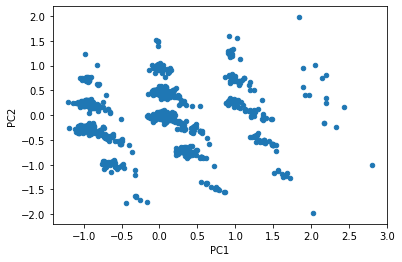

In [731]:
words_df_pca.plot.scatter(x="PC1", y="PC2")

Here is the gaph again to remind you of the distinct clusters. We can see four clusters so I am going to tell the algorithm that we want four clusters.

I am going to start with k-means.

In [732]:
clusters4 = KMeans(n_clusters=4)

In [733]:
clusters4.fit(words_df_pca.loc[:,["PC1", "PC2"]]) #only fitting the clusters on the two PCA components

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [734]:
centroids = clusters4.cluster_centers_ #getting the centers
clusters_kmeans4 = clusters4.labels_ #getting the labels

The centroids represent the principal components coordinates where the centers of each cluster are in PCA space.

In [735]:
centroids # I will only print this out once because while it is cool, it is not needed in this analysis

array([[ 0.08324062,  0.37457654],
       [ 0.12199566, -0.78548831],
       [ 1.30547731,  0.03400278],
       [-0.91004257,  0.01814564]])

In [736]:
clusters_kmeans4 # these are the values of the clusters stored in a numpy array

array([1, 0, 3, ..., 3, 0, 1], dtype=int32)

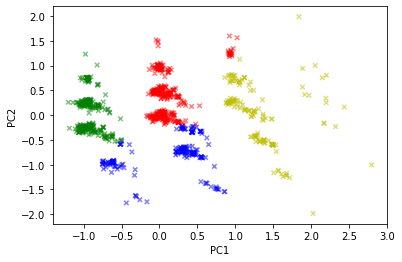

In [737]:
clusters_kmeans4 = pd.Series(clusters_kmeans4).map({ # mapping each cluster to a color
    0: "r",
    1: "b",
    2: "y",
    3: "g"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_kmeans4, marker="x", alpha=.5)

That was surprising in how it grouped up these observations into different groups than the ones that I had assumed just by looking at the graph and had created manually above.

Let me now go to three clusters.

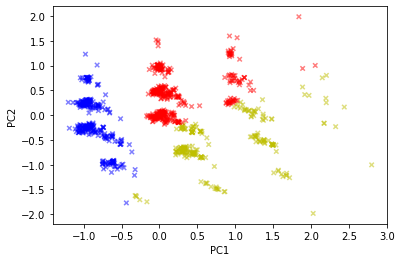

In [738]:
clusters = KMeans(n_clusters=3)
clusters.fit(words_df_pca.loc[:,["PC1", "PC2"]])
centroids = clusters.cluster_centers_
clusters = clusters.labels_
clusters_kmeans3 = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_kmeans3, marker="x", alpha=.5)

Maybe the computer is picking up on something that I am not aware of, but to me these seem like the wrong clusters. I would say that it could be caused by varying starting positions, however I have run these cells many times. Lets try hierarchical clustering and see if we see any different results.

In [739]:
clusters = AgglomerativeClustering(n_clusters=4, # I am using 4 clusters
                                affinity="euclidean",
                                linkage="complete")  #note that I am using euclidean and complete linkage

In [740]:
clusters.fit(words_df_pca.loc[:,["PC1", "PC2"]])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [741]:
clusters = clusters.labels_

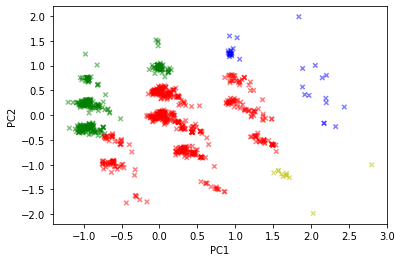

In [742]:
clusters_hier4_complete = pd.Series(clusters).map({ # mapping the clusters to colors
    0: "r",
    1: "b",
    2: "y",
    3: "g"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_hier4_complete, marker="x", alpha=.5)

This is different from the clusters of any k-means trial that we had. Lets now try single linkage.

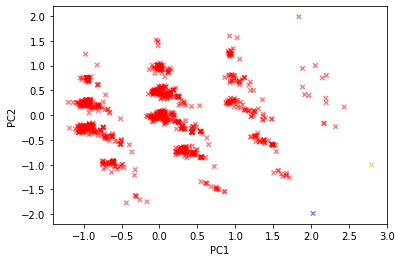

In [743]:
clusters = AgglomerativeClustering(n_clusters=4, 
                                affinity="euclidean", 
                                linkage="single") # note the single linkage here
clusters.fit(words_df_pca.loc[:,["PC1", "PC2"]])
clusters = clusters.labels_
clusters_hier4_single = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_hier4_single, marker="x", alpha=.5)

Single linkage definitely failed when it comes to clustering on this data (we do not get that much information from 3 clusters containing only one point each). It labeled all points as red except for 3, one being yellow, one blue, and one green. You were not wrong in class when you said that it makes a big difference the different kind of linkage that you choose!

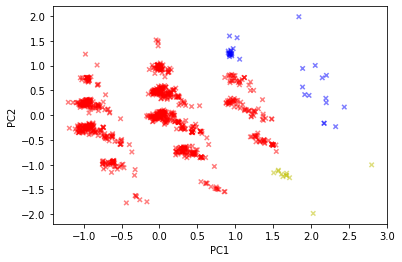

In [744]:
clusters = AgglomerativeClustering(n_clusters=3, 
                                affinity="euclidean",
                                linkage="complete")
clusters.fit(words_df_pca.loc[:,["PC1", "PC2"]])
clusters = clusters.labels_
clusters_hier3_complete = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_hier3_complete, marker="x", alpha=.5)

With 3 clusters and complete linkage we do a little bit better with hierarchical clustering.

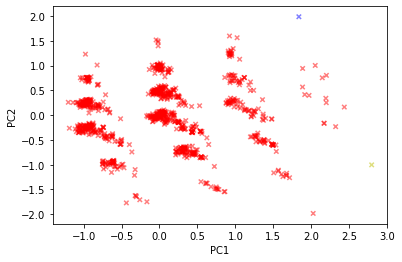

In [745]:
clusters = AgglomerativeClustering(n_clusters=3, 
                                affinity="euclidean",
                                linkage="single")
clusters.fit(words_df_pca.loc[:,["PC1", "PC2"]])
clusters = clusters.labels_
clusters_hier3_single = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_hier3_single, marker="x", alpha=.5)

Once again single linkage performs quite poorly.

I will attempt to switch the distance metric to cosine distance since these are words that we are dealing with and we have seen that cosine similarity works well with words.

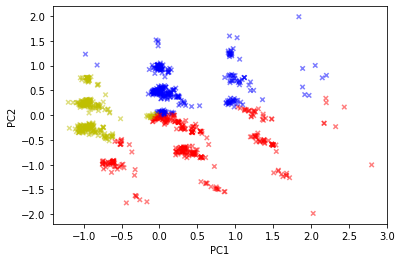

In [746]:
clusters = AgglomerativeClustering(n_clusters=3, 
                                affinity="cosine",
                                linkage="complete")
clusters.fit(words_df_pca.loc[:,["PC1", "PC2"]])
clusters = clusters.labels_
clusters_hier3_complete = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_hier3_complete, marker="x", alpha=.5)

Cosine similarity provides a more even spread in terms of the various clusters. This is an example of when I havce no way of evaluating my results. I chose to do a secondary objective where there was no classification and I did not realize fully the difficulties that can possibly come along with that. I feel like at this point this is almost like an art show and I am picking which graph looks the prettiest. The only assessment that I could possibly do on these clusters would be to manually go in and look at the words in each cluster.

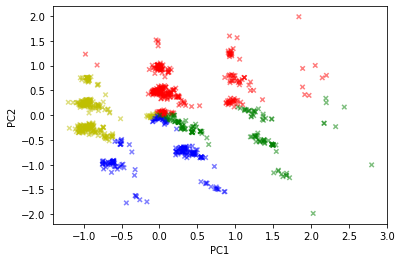

In [747]:
clusters = AgglomerativeClustering(n_clusters=4, 
                                affinity="cosine",
                                linkage="complete")
clusters.fit(words_df_pca.loc[:,["PC1", "PC2"]])
clusters = clusters.labels_
clusters_hier4_complete = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g"
})

words_df_pca.plot.scatter(x="PC1", y="PC2", 
                     c=clusters_hier4_complete, marker="x", alpha=.5)

I will stop here with the visuals of clustering as there is no real way to assess the results. I will finish the "clustering visuals/artshow" section of my second objective with a dendrogram using euclidean and complete as well as a dendrogram using euclidean and single. Note that in terms of cluster spread the complete group appears to perform better (not all observations are classified as the green cluster). This is yet another example illustrating the importance of linkage in clustering, which some might find as surprising since it seems like such a mundane difference.

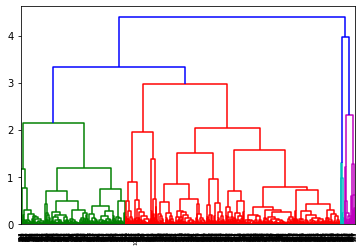

In [748]:
complete = linkage(words_df_pca.loc[:,["PC1", "PC2"]], method="complete", metric="euclidean")
dendrogram(complete);

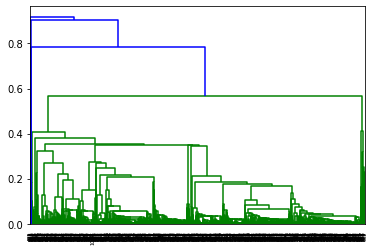

In [749]:
single = linkage(words_df_pca.loc[:,["PC1", "PC2"]], method="single", metric="euclidean")
dendrogram(single);

The complete dendrogram suggests that there are really four unique groups where 2 of them seem to occupy roughly 90% of the questions that I sampled. When we look at single linkage on the other hand I do not really know what to think, we see that all the questions were classified to one group (at least below .6 on the y-axis).

I suppose that now would be as good of a time as any to check how much of the variance the first two principal components explain, while keeping in mind that the dimension of the original space was over 1,000.

In [750]:
pca.explained_variance_

array([0.54854623, 0.36135437])

It appears that our first principal component explained 54% of the variance in the data, while the second principal component explained 36%. This is incredibly good given the over 1000 variables in the data frame. 

Since we discovered from the PCA plot that it appeared that there were four "distinct" components we can use the setting for four clusters even if we cannot visualize the data any more. This illustrates a benefit of using PCA prior to other machine learning techniques-its aid of visualization.

In [751]:
kmeansraw = KMeans(n_clusters=4)

In [752]:
kmeansraw.fit(words_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [753]:
clusters = kmeansraw.labels_

Lets add these labels to the end of our questions data frame. But first make a copy for safe keeping.

In [754]:
words_df_ = words_df.copy()

The clusters are fairly evenly distributed across the four groups.

In [756]:
words_df_["Cluster Labels"].value_counts() #printing out the value counts

2    313
1    272
0    222
3    194
Name: Cluster Labels, dtype: int64

In [758]:
word_clusters = pd.DataFrame(all_questions)

In [759]:
word_clusters["Question Cluster Labels"] = clusters

In [909]:
word_clusters.head(10)

,question_text,Question Cluster Labels,Document Titles
0,which is the most common use of opt-in e-mail ...,0,Email marketing
1,how i.met your mother who is the mother,1,The Mother (How I Met Your Mother)
2,what type of fertilisation takes place in humans,2,Human fertilization
3,who had the most wins in the nfl,3,List of National Football League career quarte...
4,what happened to the lost settlement of roanoke,0,Roanoke Colony
5,what are the different regions of africa and h...,0,List of regions of Africa
6,who played mantis guardians of the galaxy 2,0,Pom Klementieff
7,who did the voice of the magician in frosty th...,3,Frosty the Snowman (film)
8,what indian tribe did the acadians form friend...,1,History of the Acadians
9,what is considered the outer banks in north ca...,3,Outer Banks


These clusters were determined from the raw data rather than from the data that had PCA applied to it. Once again lets see if there is any information we can get from the clusters with regards to the length of the words in order to see if we can determine if the groupings are similar to the groupings found by PCA. It turns out that due to the fact that the label of the groupings doesn't matter (but rather the content) that it is quite difficult to see how and if two different clusterings are similar to each other, at least I was not able to come up with a simple way to do it.

In [761]:
question_group_0 = word_clusters[word_clusters["Question Cluster Labels"] == 0] # splitting the data into four groups
question_group_1 = word_clusters[word_clusters["Question Cluster Labels"] == 1]
question_group_2 = word_clusters[word_clusters["Question Cluster Labels"] == 2]
question_group_3 = word_clusters[word_clusters["Question Cluster Labels"] == 3]

In [762]:
print(question_group_0["question_text"].apply(lambda x : len(x.split())).mean()) # calculating the mean lengh of 
print(question_group_1["question_text"].apply(lambda x : len(x.split())).mean()) # each group
print(question_group_2["question_text"].apply(lambda x : len(x.split())).mean())
print(question_group_3["question_text"].apply(lambda x : len(x.split())).mean())

9.617117117117116
9.106617647058824
8.833865814696486
9.164948453608247


Surprisingly PCA does not pick up on the length of the word to any noticible degree here. The various word lengths across the different groups appear to be random and uniformally distributed. These are some promising results since length of word is definitely not something the requires clustering and PCA to determine, I am trying to dig deeper and extract meaning of words by themselves and how they fit together with each other.

Now lets extract the name of the wikipedia article and add that to the data frame that we are looking at.

In [763]:
title_url = training_frame["document_url"] # this is some behind the scenes data processing

In [764]:
pattern = re.compile("(?<=\=)(.*?)(?=\&)") # regex for extracting title from url

In [765]:
document_titles = []
for i in range(len(title_url)):
    document_titles.append(pattern.search(title_url[i]).group(0))

In [910]:
document_titles.head(10)

0                                      Email marketing
1                   The Mother (How I Met Your Mother)
2                                  Human fertilization
3    List of National Football League career quarte...
4                                       Roanoke Colony
5                            List of regions of Africa
6                                      Pom Klementieff
7                            Frosty the Snowman (film)
8                              History of the Acadians
9                                          Outer Banks
dtype: object

I have now gotten a list of all the document titles in the same order as the questions are. Note that there are some unwanted symbols, namely the spaces are underscores and there are scattered percent signs that could throw off the results.
Lets clean these titles up a little bit.

In [767]:
document_titles = pd.Series(document_titles)
document_titles = document_titles.apply(lambda x : " ".join(x.split("_")))

I am now going to append the list of document titles to the end of my data frame and cluster the titles with the same parameters that I used to cluster the questions.

In [768]:
word_clusters["Document Titles"] = document_titles

In [911]:
word_clusters

,question_text,Question Cluster Labels,Document Titles
0,which is the most common use of opt-in e-mail ...,0,Email marketing
1,how i.met your mother who is the mother,1,The Mother (How I Met Your Mother)
2,what type of fertilisation takes place in humans,2,Human fertilization
3,who had the most wins in the nfl,3,List of National Football League career quarte...
4,what happened to the lost settlement of roanoke,0,Roanoke Colony
...,...,...,...
996,the area between the tigris and euphrates rivers,1,Tigris%E2%80%93Euphrates river system
997,the most recent revision of the apa ethics cod...,0,APA Ethics Code
998,toby keith - i wanna talk about me,2,I Wanna Talk About Me
999,where does an apple a day keeps the doctor awa...,1,An apple a day keeps the doctor away


Now I am going to vectorize the document titles, using the usual string of commands.

In [770]:
doc_titles = word_clusters["Document Titles"]

In [771]:
vec = CountVectorizer()

In [772]:
vec.fit(doc_titles)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [773]:
vec_titles = vec.transform(doc_titles)

In [774]:
title_frame = pd.DataFrame.sparse.from_spmatrix(vec_titles)

Now I am fitting kmeans clustering on the titles.

In [775]:
kmeansrawtitles = KMeans(n_clusters=4)

In [776]:
kmeansrawtitles.fit(title_frame)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [777]:
titles_labels = kmeansrawtitles.labels_ # extracting the labels

In [778]:
pd.Series(titles_labels).value_counts()

1    752
0    195
3     49
2      5
dtype: int64

This clustering did not work as I had expected and hoped that it would (where my hope is much determined on evenly spread clusters. This is something that I need to be careful about in my next project). Let me now try to remove the non-alpha numeric characters and see if that makes a difference in the clustering results.

In [779]:
document_titles = pd.Series(document_titles)

In [780]:
document_titles = document_titles.apply(lambda x : " ".join(x.split("_"))) # this is removing the _ separator

In [781]:
pattern = re.compile("[%]") # this is removing the % symbol
for index in indexes:
    document_titles[index] = re.sub(pattern, " ", document_titles[index])

In [782]:
document_titles

0                                         Email marketing
1                      The Mother (How I Met Your Mother)
2                                     Human fertilization
3       List of National Football League career quarte...
4                                          Roanoke Colony
                              ...                        
996                 Tigris%E2%80%93Euphrates river system
997                                       APA Ethics Code
998                                 I Wanna Talk About Me
999                  An apple a day keeps the doctor away
1000                                                Oxide
Length: 1001, dtype: object

In [783]:
vec = CountVectorizer()
vec.fit(doc_titles)
vec_titles = vec.transform(doc_titles)
document_titles_v = pd.DataFrame.sparse.from_spmatrix(vec_titles)

In [784]:
kmeansraw = KMeans(n_clusters=4)
kmeansrawtitles.fit(document_titles_v)
titles_labels = kmeansrawtitles.labels_
pd.Series(titles_labels).value_counts()

0    757
2    155
1     86
3      3
dtype: int64

We still see see a somewhat uneven distribution of clusters in the data when using kmeans. Let's give it one more shot, this time using heirarchical clustering.

In [785]:
title_hier = AgglomerativeClustering(n_clusters=4, 
                                affinity="euclidean",
                                linkage="complete")

In [786]:
title_hier.fit(cleaned_df)
clusters_unmod = title_hier.labels_

In [787]:
pd.Series(clusters_unmod).value_counts()

0    998
3      1
2      1
1      1
dtype: int64

Surprisingly when we do the clustering on the titles using complete and hierarchical we get extremely uneven clustering groupings. This is potentially due to the fact that there are so few words in most of the titles.

I am going to give one last ditch attempt at making graphs and using PCA, this time on the titles.

After looking at these results, this is what I have came to the conclusion of: I do not think that it is the most effective to use the count vectorizer and so I will look into other pre-trained models such as word2vec, glove and BERT. My idea of where to go next is:
- I still want to try to see if I can find patterns in the questions and break them it into categories based on what was asked.
- I can possibly use the entire document text as my corpus to try to increase the number of terms that the each observation is "trained" on so that it has a larger vocabulary and thus is possibly more accurate.

# Intermission

# Getting Smart - Using Spacy

I am now going to explore the data a little bit more, now using a popular natural language processing package called spacy. We first need to load it in and get their pre-trained vectors. Upon doing some reseach I saw that they are contextually trained which is extra appealing for this particular task that I am attempting.

In [788]:
import spacy
nlp = spacy.load('en_core_web_md/en_core_web_md-2.1.0')

I am defining two functions, one to calculate cosine similarity and one that just returns a vectorized version of the word.

In [789]:
from numpy import dot
from numpy.linalg import norm

def cosine(v1, v2):
    if norm(v1) > 0 and norm(v2) > 0:
        return dot(v1, v2) / (norm(v1) * norm(v2))
    else:
        return 0.0
    
def vec(s):
    return nlp.vocab[s].vector

These are just a few tests to see if the functions and packages are working properly.

In [912]:
cosine(vec("dog"), vec("cat")) > cosine(vec("apple"), vec("chair"))

True

In [913]:
cosine(vec("dog"), vec("physics")) > cosine(vec("apple"), vec("pear"))

False

I find that result pretty amusing. 

I now define a function that returns the 10 closest vectors in cosine similarity to the vectors in its "vocabulary" which are just unique words that been put into a list that is passed into the function. This is a more manual process than the vectorizers that we have gotten used to using.

In [792]:
def spacy_closest(token_list, vec_to_check, n=10):
    return sorted(token_list,
                  key=lambda x: cosine(vec_to_check, vec(x)),
                  reverse=True)[:n]

We could "fit" our token_list to the words in our entire corpus of documents, but that could potentially be overkill since we are removing all non-unique words. First lets look through the text of all the questions to see the above function in action.

In [793]:
split_questions = all_questions.apply(lambda row : row.split(" "))

In [794]:
new_list =[]
for x in split_questions:
    new_list.extend(x) # note that extend, not append gives us all the words in one long list.

In [914]:
tokens = list(set([w for w in new_list if w.isalpha()])) # now we extract only the unique alpha numeric words
# I know all words are alpha numeric but everything is stored as a string so we want to remove numbers 
#as well as punctuation

In [796]:
"There are " + str(len(tokens)) + " unique words in our vocabulary."

'There are 2518 unique words in our vocabulary.'

Here is a quick test of our closest function as well as putting spacys context claim to the test. 
I am going to add the following vectors.

In [919]:
new = vec("water") + vec("freeze")

In [920]:
spacy_closest(tokens, new)

['seawater',
 'water',
 'potable',
 'Seawater',
 'Water',
 'thaw',
 'Thaw',
 'Freeze',
 'freeze',
 'Freezing']

These were the closest words in all of our questions to the word that we were going for. They seem like a reasonable result for the addition of those two vectors.

Lets now look at the document text and use regular expressions to clean it.

In [799]:
doc_text = training_frame.document_text

In [800]:
doc_text = doc_text.apply(lambda value: re.sub("<.*?>", "",value)) # removing everything between < and >

In [801]:
split_docs = doc_text.apply(lambda row : row.split(" "))

In [802]:
new_list =[]
for x in split_docs: # getting one long list
    new_list.extend(x)

In [803]:
new_list = [v for v in new_list if v.isalpha()] # ensuring only words

In [805]:
tokens = list(set([w.lower() for w in new_list if w.isalpha()]))

In [806]:
"There are " + str(len(tokens)) + " unique words in our vocabulary."

'There are 142475 unique words in our vocabulary.'

With many more words in our vocabulary we are likely to be able to achieve better results than when we had much fewer words. Lets run a few quick more test runs before we put this to the test to try to categorize the questions and/or documents.

In [807]:
spacy_closest(tokens, vec("dog"))

['canine',
 'hound',
 'dog',
 'kennel',
 'dogs',
 'terrier',
 'retriever',
 'husky',
 'poodle',
 'greyhound']

This function takes a lot longer because we look through every single token and here there are many more tokens than when the tokens were just coming from the unique words in the questions. Note though that we are still getting good results.

In [808]:
spacy_closest(tokens, vec("basketball"))

['lacrosse',
 'basketball',
 'volleyball',
 'footballing',
 'gridiron',
 'football',
 'kickball',
 'futbol',
 'futsal',
 'handball']

In [809]:
spacy_closest(tokens, vec("I like turtles and dogs because they are good"))

['lanning',
 'kalaya',
 'liclo',
 'fuelling',
 'birnbaum',
 'dautry',
 'lilyhammer',
 'scaricati',
 'timm',
 'nadusthundu']

Note that any non-sensical statement gives us these bad results. More importantly this last example shows that for these purposes we **cannot** direclty plug in sentences to the vec function, it can only handle words. As a result we have to come up with a way to get the meaning out of sentences in order to do any sort of clustering, classification or frankly any analysis with either the questions or the document text.

One way to try and mathematically extract the meaning of sentences it to take the average of their word vectors. The following function does exactly that. There could potentially be a better way to do this, but I do not think this function I wrote is much worse than whatever built ins they couldhave since I use numpy.

In [810]:
def meanv(x):
    for i in range(len(x)):
        if i == 0:
            final = x[i]
        else:
            final + x[i]
    return final/len(x)

The following displays our new function in action.

In [811]:
spacy_closest(tokens, meanv([vec("apple"), vec("banana"), vec("lemon")]))

['apple',
 'blackberry',
 'prunes',
 'pears',
 'apples',
 'iphone',
 'fig',
 'fruit',
 'strawberry',
 'popsicle']

Now lets look at what my algorithm finds as the most similar words to the first question.

In [813]:
first_question = all_questions[0]

In [814]:
first_question

'which is the most common use of opt-in e-mail marketing'

In [815]:
spacy_closest(tokens, meanv([vec(c) for c in first_question.split(" ") if c.isalpha()]))

['which',
 'that',
 'also',
 'itself',
 'it',
 'thus',
 'however',
 'where',
 'but',
 'only']

The most common words *to the mean vector of* the first question are words that are very common and do not find the meaning very well.

This is a sign that possibly using stop words might benefit us in terms of accuracy. Lets import spacys stop words, since they are pre-determined and they might work well with spacys built in vectors that I am also using.

In [816]:
from spacy.lang.en.stop_words import STOP_WORDS # importing the stop words

I now print out 10 random stop words just to get a feel for how common these words are, based on the ones that I see there are less common words than "the" and "and". I do not know if this is a good or bad thing, and I suppose that I will just have to wait until I get results to make a decision on that.

In [817]:
for i in range(10):
    item = STOP_WORDS.pop()
    print(item)

back
but
hers
a
're
over
they
ca
rather
seemed


Lets manually go in and only use tokens that are not stop words. The other option would be to also remove the stop words from each question text, however I think that removing the stop words from the tokens should be enough given the way that I am implementing my closest function. **This remains to be see however.**

Notice I add the ony extra condition that they are not in the list of stop words, I use set to remove any duplicates words, since we only need one copy of each word the way that my function is set up.

In [820]:
tokens = list(set([token.lower() for token in new_list if token.lower() not in list(STOP_WORDS) and token.isalpha()]))

In [923]:
"We now have " + str(len(tokens)) + " words in our vocabulary."

'We now have 170954 words in our vocabulary.'

It looks like we correctly removed the unwanted stop words. Now lets try the same procedure as before on the first question, but this time with my improved list of tokens.

In [822]:
first_question

'which is the most common use of opt-in e-mail marketing'

In [823]:
spacy_closest(tokens, meanv([vec(c) for c in first_question.split(" ") if c.isalpha()]))

['that',
 'but',
 'actually',
 'rather',
 'essentially',
 'fact',
 'generally',
 'they',
 'given',
 'so']

Note that in this case we are removing the stop words from the available words that this vector can be close to but we are not removing said stop words from the question itself as I mentioned before. Despite that these actually seem like *better* results. I am not thrilled with the fact that "opt-in", email", and "marketing" were all not selected. There is much room for improvement.

I think that the function that I am using is very slow and I need something faster if I am going to do this in any repeated way, but I might just keep the scale low so that I can do a more in depth analysis on the specific questions, as I said before this is very unsupervised. Lets take a look at some more questions and see if the spacy_closest function is coming up with any worthwhile results.

In [824]:
second_question = all_questions[1]

In [825]:
second_question

'how i.met your mother who is the mother'

In [826]:
spacy_closest(tokens, meanv([vec(c) for c in second_question.split(" ") if c.isalpha()]))

['understand',
 'know',
 'explain',
 'tell',
 'that',
 'think',
 'way',
 'learn',
 'so',
 'sure']

I feel like this is picking up on the fact that this sentence is a question a little bit too much rather than getting more at the context of the question itself.

In [827]:
third_question = all_questions[2]

In [828]:
third_question

'what type of fertilisation takes place in humans'

In [829]:
spacy_closest(tokens, meanv([vec(c) for c in third_question.split(" ") if c.isalpha()]))

['know',
 'think',
 'thing',
 'that',
 'exactly',
 'thought',
 'tell',
 'understand',
 'believe',
 'sure']

In [830]:
fourth_question = all_questions[3]

In [831]:
fourth_question

'who had the most wins in the nfl'

In [832]:
spacy_closest(tokens, meanv([vec(c) for c in fourth_question.split(" ") if c.isalpha()]))

['whose',
 'he',
 'knew',
 'knows',
 'they',
 'have',
 'had',
 'people',
 'wanted',
 'know']

There are a few things of note that come to mind upon looking at these first four observations. As I noted previously my closeness function is picking up too much on the fact that the phrase is a question, but also I am now getting the sense that my choice to only remove stop_words from the tokens list and not the questions could be detrimental to my results.

Consider this:

If the word shows up in the question it is still going to affect the value for the mean vector for that sentence. When it comes time for spacy_closest to find the closest word vectors to the mean of the sentence it is not going to have the luxury of using any of the words that are stop words and this might hinder our results, since the stop words were made stop words since they are the most common words! I have a way to remedy this problem though. I am now going to do two things:
- I am going to add the common question terms to the list of stop words
- I am going to remove stop words from the questions themselves to alleviate the possible hinderance in prediction that I just mentioned.

The first thing that I am going to do is make a list of all of the stop words as well as all of the question related words (I know I already imported the list of stop words but the uppercase was annoying). For the question related words I am going to first consider: who, what, when, where and why as those seem to me to be the most "questiony" words that I know of.

In [833]:
stop_words = list(STOP_WORDS)

In [834]:
stop_words.extend(["who", "what", "when", "where", "why"]) #extending the list

In [835]:
stop_words = list(set(stop_words)) #this is just in case some of those words were already in the list
# or if I ran the above line of code too many times.

Now I am ready to create my new tokens. These are what I am going to use to remove from each question.
Below I create the tokens and print out the first 10 questions to try out the removal procedure with.

In [836]:
tokens = list(set([token.lower() for token in new_list if token.lower() not in list(stop_words) and token.isalpha()]))

In [837]:
top_10_questions = all_questions[:10]

In [838]:
top_10_questions

0    which is the most common use of opt-in e-mail ...
1              how i.met your mother who is the mother
2     what type of fertilisation takes place in humans
3                     who had the most wins in the nfl
4      what happened to the lost settlement of roanoke
5    what are the different regions of africa and h...
6          who played mantis guardians of the galaxy 2
7    who did the voice of the magician in frosty th...
8    what indian tribe did the acadians form friend...
9    what is considered the outer banks in north ca...
Name: question_text, dtype: object

This function gets the job done.

In [839]:
fixed_top_questions = []
for i in range(len(top_10_questions)):
    new_string = []
    temp = top_10_questions[i].split(" ")
    for char in temp:
        if char not in stop_words:
            new_string.append(char)
    fixed_top_questions.append(new_string)
fix2 = []
for i in range(len(fixed_top_questions)):
    fix2.append(" ".join(fixed_top_questions[i]))
fixed_top_questions = pd.Series(fix2)

In [840]:
fixed_top_questions

0                  common use opt-in e-mail marketing
1                                 i.met mother mother
2               type fertilisation takes place humans
3                                        had wins nfl
4                    happened lost settlement roanoke
5             different regions africa do they differ
6                    played mantis guardians galaxy 2
7                       voice magician frosty snowman
8    indian tribe acadians form friendships alliances
9               considered outer banks north carolina
dtype: object

Since this is a very manual procedure I am going to go by one by one and check the closest words to the mean vectors of the first four questions.

In [841]:
first_question = fixed_top_questions[0]
first_question

'common use opt-in e-mail marketing'

In [842]:
spacy_closest(tokens, meanv([vec(c) for c in first_question.split(" ") if c.isalpha()]))

['common',
 'popularly',
 'colloquially',
 'commonly',
 'certain',
 'uncommon',
 'associated',
 'particular',
 'types',
 'prevalent']

This is much better in my opinion it picked up on the term common and popularity, as compared to before when we were only able to really pick up on the fact that it was a question being asked (all of the observations that I am currently considering are questions, so that is not very informative at all). I will print out the corresponding question as well so you can see how it was affected by the stop words "cropping" it (to hopefully its meaning!).

In [843]:
second_question = fixed_top_questions[1]
second_question

'i.met mother mother'

In [844]:
spacy_closest(tokens, meanv([vec(c) for c in second_question.split(" ") if c.isalpha()]))

['mother',
 'daughter',
 'grandmother',
 'matriarch',
 'homemaker',
 'stepfather',
 'father',
 'sister',
 'wife',
 'stepmother']

We see some family members here.

In [845]:
third_question = fixed_top_questions[2]
third_question

'type fertilisation takes place humans'

In [846]:
spacy_closest(tokens, meanv([vec(c) for c in third_question.split(" ") if c.isalpha()]))

['type',
 'types',
 'kind',
 'sort',
 'specific',
 'example',
 'particular',
 'similar',
 'different',
 'style']

I bet that we would have picked up on the uncommon word fertilization if they had managed to spell it right!

In [847]:
fourth_question = fixed_top_questions[3]
fourth_question

'had wins nfl'

In [848]:
spacy_closest(tokens, meanv([vec(c) for c in fourth_question.split(" ") if c.isalpha()]))

['had',
 'came',
 'took',
 'got',
 'have',
 'went',
 'knew',
 'gave',
 'brought',
 'turned']

We did not do as well on this one in my opinion, but a three word question is tough.

I now have viewed the top four questions in both "versions" of my algorithm. I think, although I do not have a mathematical metric, that my results have been much improved in the second iteration now that I am removing the stop words and also adding the question words and I believe that the statement that I made above was correct. A few things come to mind upon viewing these contrasting results.
- It would be good if words that had more meaning, such as the word nfl in question 4 would be weighted more, similar to how it would be in a tf-idf, but I am not sure how I would go about doing that since I am using spacy's built in vectors and very simple functions for assessing vector similarity.
- I am thinking of ways that I could get a definitive, numerical answer for what the best list of spacially proximate mean vectors to my question is. Part of the reason that I chose this second objective was because I wanted to do some sort of unsupervised task and I feel that trying to get a "correct answer" is veering too close to our main objective of classification.
- I could automate this process such that it is easy to see the various lists of words close to the mean vector of a given question while still having no real scoring metric, however I am going to move on to slightly different ideas that I have.

What I was just doing above is fairly slow and takes a lot of manual work. We had to look at each list of the most similar words corresponding to a stripped down question's mean vector where any word in the question that was either a stop word (subjective) or a word that was commonly found in questions (subjective) was removed.

Computers are good at finding patterns in the data, we just have to give them a chance to do it.

Let me first do a little bit more cleaning on the questions. I am just going to remove the . and - tokens because I have seen them and they cannot be helping.

In [849]:
all_questions = all_questions.apply(lambda x : " ".join(x.split(".")))
all_questions = all_questions.apply(lambda x : " ".join(x.split("-")))

In [850]:
first_question = all_questions[0]

In [851]:
first_question 

'which is the most common use of opt in e mail marketing'

I noticed that some questions were either separated by "-" or "." due to user error, this is something that cannot improve accuracy of the model and so I will get rid of them. You can see this was fixed on the first question which you are probably all too familiar with now.

I am keeping this notion of removing words that are stop words (or question related words) in this section of my secondary objective, because if I found such promising results in the section above I do not see why thos strategy should not deliver good results now in a different, but similar, setting. Data science is very iterative after all and if you find something works it probably a good decision to stick with it.

I now define a function that automatically calculates the mean vector for a sentence, using the same mean vector function that I was using before.

In [852]:
def sentvec(s):
    return meanv([vec(c) for c in s.split(" ") if c.isalpha() and c.lower() not in stop_words])

In [853]:
vectorized_question = sentvec(first_question) 

In [854]:
vectorized_question[:30] #printing out the first 30 components of this vector

array([-7.5180002e-02,  3.4659998e-03, -7.1839996e-02, -2.7884999e-02,
        2.2653334e-02, -3.4059998e-02, -4.3970000e-02, -2.4180001e-02,
       -3.3763334e-02,  3.3821666e-01, -5.3521667e-02, -4.9103335e-02,
        7.7581666e-02,  7.9080000e-06, -4.4225004e-02,  3.5818335e-02,
       -1.1858833e-02,  2.9381666e-01, -3.2028332e-02,  3.4908336e-02,
       -5.9171665e-02,  1.4789500e-02, -9.0640001e-02, -3.8759999e-02,
        7.9083331e-02, -6.2668331e-02,  5.9968334e-02, -3.2126668e-03,
       -6.0979999e-03,  3.4943331e-02], dtype=float32)

Looks like a nice random vector.

Now I am going to loop through and get the mean vector for each question in all questions. I am then going to line each vector up and get them into a form that is amiable to analysis (dataframe).

In [855]:
results = []
all_questions_list = []
for i in range(len(all_questions)):
    results.append(sentvec(all_questions[i]))

I can use the transpose function of a data frame so that each observation is a row as hoped for.

In [857]:
pd.DataFrame(results[0]).T

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.07518,0.003466,-0.07184,-0.027885,0.022653,-0.03406,-0.04397,-0.02418,-0.033763,0.338217,...,-0.086975,0.019682,-0.065873,-0.046742,-0.050225,0.110153,-0.024222,-0.103862,0.017122,-0.007178


In [858]:
question_vectors = pd.DataFrame(results)

In [942]:
question_vectors.head(5)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,PC1,PC2
0,-0.075180,0.003466,-0.071840,-0.027885,0.022653,-0.034060,-0.043970,-0.024180,-0.033763,0.338217,...,-0.065873,-0.046742,-0.050225,0.110153,-0.024222,-0.103862,0.017122,-0.007178,-0.267968,-0.244682
1,0.046832,0.101488,-0.127935,-0.138705,0.009929,0.032217,0.112843,-0.147872,0.038978,0.378425,...,-0.097855,-0.081207,0.158627,-0.047275,0.013512,0.041237,0.046893,0.134685,-0.025900,0.284697
2,0.032674,0.037282,-0.076780,-0.058356,-0.007103,0.015673,0.032476,-0.084266,-0.015124,0.207780,...,-0.041688,0.013165,-0.011194,0.085686,-0.074116,-0.005106,0.051784,0.013222,-0.235349,-0.204261
3,0.028767,0.094930,0.021331,-0.057620,-0.048200,0.001213,0.037303,-0.067507,0.014020,1.117967,...,0.107137,0.114673,0.117197,-0.094053,0.021554,0.056703,0.112083,-0.051547,0.563424,-0.447368
4,-0.020554,0.081973,-0.029710,0.017950,-0.019359,-0.004246,-0.044645,0.034162,-0.017335,0.756750,...,0.048945,0.027440,0.096500,-0.056072,-0.109697,0.065008,0.053822,0.022264,0.274931,-0.105651


We now have a data frame that has as its rows, questions in vectorized form with each column being one of the components of said vector. I decided to put the vectors on their "side" like this because we are used to rows corresponding to observations and columns corresponding to variables. This familiar tabular data form will allow us to perform our usual machine learning or unsupervised tasks easily without much more pre-processing.

I now fit PCA once again.

In [863]:
pca = PCA(n_components = 2)

pca.fit(question_vectors)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [864]:
pca_question_data = pca.transform(question_vectors)

In [865]:
pca_question_data # my pca coordinates

array([[-0.26796794, -0.24468229],
       [-0.02590022,  0.28469699],
       [-0.23534882, -0.20426107],
       ...,
       [-0.34798072,  0.76288131],
       [-0.33324386,  0.20505137],
       [-0.24073889, -0.13924408]])

In [866]:
new_cols = pd.DataFrame(pca_question_data,columns=["PC1","PC2"])
question_vectors = question_vectors.join(new_cols) 

In [941]:
question_vectors.head(5)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,PC1,PC2
0,-0.075180,0.003466,-0.071840,-0.027885,0.022653,-0.034060,-0.043970,-0.024180,-0.033763,0.338217,...,-0.065873,-0.046742,-0.050225,0.110153,-0.024222,-0.103862,0.017122,-0.007178,-0.267968,-0.244682
1,0.046832,0.101488,-0.127935,-0.138705,0.009929,0.032217,0.112843,-0.147872,0.038978,0.378425,...,-0.097855,-0.081207,0.158627,-0.047275,0.013512,0.041237,0.046893,0.134685,-0.025900,0.284697
2,0.032674,0.037282,-0.076780,-0.058356,-0.007103,0.015673,0.032476,-0.084266,-0.015124,0.207780,...,-0.041688,0.013165,-0.011194,0.085686,-0.074116,-0.005106,0.051784,0.013222,-0.235349,-0.204261
3,0.028767,0.094930,0.021331,-0.057620,-0.048200,0.001213,0.037303,-0.067507,0.014020,1.117967,...,0.107137,0.114673,0.117197,-0.094053,0.021554,0.056703,0.112083,-0.051547,0.563424,-0.447368
4,-0.020554,0.081973,-0.029710,0.017950,-0.019359,-0.004246,-0.044645,0.034162,-0.017335,0.756750,...,0.048945,0.027440,0.096500,-0.056072,-0.109697,0.065008,0.053822,0.022264,0.274931,-0.105651


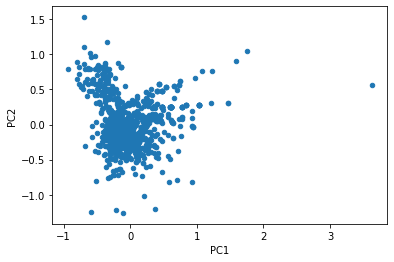

In [868]:
question_vectors.plot.scatter("PC1", "PC2")

Nice, we see some short of shape emerging after the PCA is performed.

In [869]:
outlier_right = question_vectors[(question_vectors["PC1"] > 3)]

In [870]:
print(all_questions[outlier_right.index])

162    who's doing the halftime show in 2018
Name: question_text, dtype: object


In [939]:
outlier_above = question_vectors[(question_vectors["PC2"] > 1.5)]

In [940]:
print(all_questions[outlier_above.index])

605    what is 2 samuel about in the bible
Name: question_text, dtype: object


These do not seem like such strange of outliers, I wonder why PCA is indentifying them as being so much more in the direction of those two principal components than any of the other data points? This is a question that I will probably not be able to answer, it could just be random outliers, I am not familiar enough with the nuts and bolts of PCA to know how that would happen, but I do not have any other answer as to why they are all the way out there.

Let me try some kmeans clustering with 5 clusters. I chose 5 somewhat randomly but it is partially because I want there to be 5 groups in the data. An aspect of clustering that is somewhat unfortunate is the fact that you have to specify the number of clusters that you want before you even know how the data is grouped. If the data is in many dimensions than your best bet is to try doing PCA to get an idea of how the data visually breaks up, but it may break up differently after performing PCA compared to how it is spread out in the natural dimension that it exists in.

In [873]:
model = KMeans(n_clusters=5)
model.fit(question_vectors.loc[:,["PC1", "PC2"]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [874]:
clusters = model.labels_

Most of the time, I base a clustering algorithms performance by how evenly it breaks up the data since there is really no point of a clustering algorithm that classifies all into one cluster and a bunch into their own clusters.

In [875]:
pd.Series(clusters).value_counts()

2    388
0    247
3    146
1    131
4     89
dtype: int64

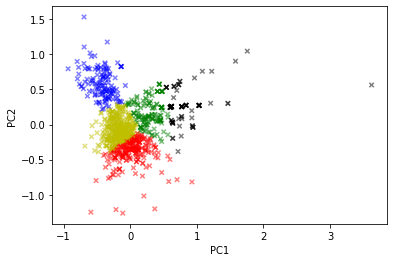

In [876]:
clusters_c = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g",
    4: "k"
})

question_vectors.plot.scatter(x="PC1", y="PC2", 
                    c = clusters_c ,marker="x", alpha=.5)

Now that is a nice looking plot!

I now have to split the data into the groups and look at each cluster. I also need to figure how to give myself a score, but I might just have to accept the fact that, that is not possible in this situation.

In [877]:
cluster_series = pd.Series(clusters)
cluster_series

0       2
1       3
2       2
3       0
4       3
       ..
996     0
997     2
998     1
999     2
1000    2
Length: 1001, dtype: int32

Now I am splitting the data into four 5 groups based on its cluster.

In [878]:
group_0 = all_questions[cluster_series[lambda x : x==0].index]

In [879]:
group_1 = all_questions[cluster_series[lambda x : x==1].index]

In [880]:
group_2 = all_questions[cluster_series[lambda x : x==2].index]

In [881]:
group_3 = all_questions[cluster_series[lambda x : x==3].index]

In [882]:
group_4 = all_questions[cluster_series[lambda x : x==4].index]

An interesting thing to note about these groupings is that when I was performing PCA I stripped out all of the stop words as well as the words that are common to questions. However, now that I am using the same "question" to index back into all_questions (the unedited list of question), I am able to see the full question corresponding to each stripped question that I pulled out to potentially better my results and make the PCA chart that you see above.

I am about to put each of the groupings through a tf-idf vectorizer and now I realize that it is a good thing that we get access to the whole question.
- It will possibly allow our tf-idf to learn the trends better since it has more data to learn from.
- It will give a more accurate measure of inverse document frequency.
- It should automatically have ...
- It will give more weight to words that were less common, a feature that was not available to use when we were using spacy's word vectors and my vector mean generator.

In [883]:
vec0 = TfidfVectorizer(stop_words = "english")
vec1 = TfidfVectorizer(stop_words = "english")
vec2 = TfidfVectorizer(stop_words = "english")
vec3 = TfidfVectorizer(stop_words = "english")
vec4 = TfidfVectorizer(stop_words = "english")

In [931]:
vec0.fit(group_0)
group_0_vec = vec0.transform(group_0)
vec1.fit(group_1)
group_1_vec = vec1.transform(group_1)
vec2.fit(group_2)
group_2_vec = vec2.transform(group_2)
vec3.fit(group_3)
group_3_vec = vec3.transform(group_3)
vec4.fit(group_4)
group_4_vec = vec4.transform(group_4)

In [932]:
zero_index_search = pd.DataFrame.sparse.from_spmatrix(group_0_vec).\
sum(axis = 0).sort_values(ascending = False).head(10).index

In [933]:
res0 = []
for item in vec0.vocabulary_.items():
    if item[1] in zero_index_search:
        res0.append(item)

In [934]:
res0

[('place', 466),
 ('does', 203),
 ('time', 607),
 ('come', 142),
 ('mean', 398),
 ('person', 459),
 ('did', 195),
 ('following', 264),
 ('world', 666),
 ('state', 573)]

I cannot say what the theme of these words are, all I can say is that they seem somewhat similar to eachother. But perhaps that is just wishful thinking.

In [927]:
pd.DataFrame.sparse.from_spmatrix(group_1_vec).\
sum(axis = 0).sort_values(ascending = False).head(10)

141    7.780284
145    6.744852
112    3.534274
491    2.437418
321    1.990748
351    1.848784
422    1.818651
25     1.708478
425    1.653191
156    1.649480
dtype: float64

In [928]:
one_index_search = pd.DataFrame.sparse.from_spmatrix(group_1_vec).\
sum(axis = 0).sort_values(ascending = False).head(10).index

In [929]:
res1 = []
for item in vec1.vocabulary_.items():
    if item[1] in one_index_search:
        res1.append(item)

In [930]:
res1

[('did', 141),
 ('does', 145),
 ('start', 425),
 ('end', 156),
 ('nba', 321),
 ('come', 112),
 ('world', 491),
 ('play', 351),
 ('american', 25),
 ('stand', 422)]

These words are different from the words above. These words are more lively.

In [893]:
two_index_search = pd.DataFrame.sparse.from_spmatrix(group_2_vec).\
sum(axis = 0).sort_values(ascending = False).head(10).index

In [894]:
res2 = []
for item in vec2.vocabulary_.items():
    if item[1] in two_index_search:
        res2.append(item)

In [895]:
res2

[('time', 1218),
 ('start', 1144),
 ('new', 818),
 ('list', 684),
 ('world', 1320),
 ('does', 352),
 ('did', 333),
 ('come', 251),
 ('india', 577),
 ('war', 1290)]

We see start occur in two in a row.

In [896]:
three_index_search = pd.DataFrame.sparse.from_spmatrix(group_3_vec).\
sum(axis = 0).sort_values(ascending = False).head(10).index

In [897]:
res3 = []
for item in vec3.vocabulary_.items():
    if item[1] in three_index_search:
        res3.append(item)

In [898]:
res3

[('did', 109),
 ('season', 347),
 ('does', 116),
 ('plays', 312),
 ('sings', 357),
 ('song', 363),
 ('love', 246),
 ('movie', 271),
 ('won', 432),
 ('episode', 132)]

In [899]:
four_index_search = pd.DataFrame.sparse.from_spmatrix(group_4_vec).\
sum(axis = 0).sort_values(ascending = False).head(10).index

In [900]:
res4 = []
for item in vec4.vocabulary_.items():
    if item[1] in four_index_search:
        res4.append(item)

In [901]:
res4

[('played', 178),
 ('plays', 179),
 ('won', 261),
 ('sang', 200),
 ('song', 219),
 ('movie', 156),
 ('did', 55),
 ('season', 207),
 ('filmed', 76),
 ('red', 189)]

Maybe I am seeing things, but to me it seems like the "flavor" of these words varies from group to group. There are many other things that I could possibly do including trying to change the parameters of the tf-idf to have it give more weight to rare words then it does now.